In [1]:
import torch
#from utility import My_Dataset
from utility import mean_and_std,get_params_and_gradients_norm,train_model
from utility import validation, early_stopping
from utility import Augmented_Dataset 
from utility import data_augmentation
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset #
from torch.utils.data import DataLoader,ConcatDataset
import torchvision.datasets as datasets 
import torchvision.transforms as T
#from torch.utils.tensorboard import SummaryWriter 
import numpy as np #
from skimage import io #
from matplotlib import pyplot as plt


/home/maria/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
import PIL 
import os 
import cv2 
from PIL import Image 
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from skimage import io 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [117]:
import torchvision.models as models
import joblib
import pickle
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
from sklearn import svm

In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: x.repeat(3,1,1)),
    #T.clone().expand(3, 224, 224),
    #T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #this mean and std is calculated on the dataset with which AlesNet has been trained 
    #T.Normalize([mean], [std]),
    #T.clone().expand(3, 256, 256),
])
#(self,root,transform =None,dimension=64,augmentation=None,flip=None,crop=None,train=False,val=False): 

In [6]:
train_dataset1 = Augmented_Dataset(root="train",transform=transforms,dimension=224,augmentation=data_augmentation,flip=False,crop=True,train=False)#,expand=True)
train_dataset2 = Augmented_Dataset(root="train",transform=transforms,dimension=224,train=False)#,expand=True)
train_dataset3 = Augmented_Dataset(root="train",transform=transforms,dimension=224,augmentation=data_augmentation,flip=True,crop=False,train=False)#,expand=True)
train_dataset4 = Augmented_Dataset(root="train",transform=transforms,dimension=224,augmentation=data_augmentation,flip=True,crop=True,train=False)#,expand=True)
augmented_dataset = ConcatDataset([train_dataset1,train_dataset2,train_dataset3,train_dataset4])
val_dataset = Augmented_Dataset(root="train",transform=transforms,dimension=224,val=True)#,expand=Tru

In [26]:
test_dataset = Augmented_Dataset(root="test",transform=transforms,dimension=224)#,expand=True)
train_loader = DataLoader(dataset = augmented_dataset, batch_size=32, shuffle=True)

In [23]:
val_loader = DataLoader(dataset = val_dataset, batch_size=64, shuffle=False)

In [27]:
test_loader =DataLoader(dataset =test_dataset, batch_size=64, shuffle=False)

In [59]:
model =  models.alexnet(pretrained=True)

In [121]:
children_counter = 0 
for n,c in model.named_children():
    print("Children Counter: ",children_counter," Layer Name: ",n,)
    children_counter+=1
    

Children Counter:  0  Layer Name:  net


In [86]:
class new_model(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = models.alexnet()
        for param in self.pretrained.parameters():
            param.requires_grad = False 
        self.children_list = []
        for n,c in self.pretrained.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x

In [125]:
model = new_model('features')

In [126]:
print(model)

new_model(
  (pretrained): None
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
)


In [63]:
def feature_extraction(train_loader, model): 
    _ = model.eval()
    with torch.no_grad():
        #for i in range(20):
        for i in range(len(train_loader)): 
            data, target = next(iter(train_loader))
            #feature = ((model(data)).numpy()).reshape((1,256*6*6))
            feature = ((model(data)).numpy()).reshape((data.shape[0],256*6*6))
            target = target.numpy()
            if (i==0): 
                res = feature 
                targets = target
            else: 
                res = np.concatenate((res,feature),axis = 0)
                targets = np.concatenate((targets,target))
    return res,targets

In [64]:
train_features, train_targets = feature_extraction(train_loader, model)

In [44]:
train_features.shape

(6016, 9216)

In [65]:
clf = OneVsRestClassifier(SVC(C=1)).fit(train_features,train_targets)

In [17]:
filename = "first_linear.joblib"

In [18]:
joblib.dump(clf, filename)

['first_linear.joblib']

In [19]:
predictions = clf.predict(train_features)


In [20]:
train_accuracy_linear = (predictions==train_targets).sum()/(len(predictions))

In [66]:
train_accuracy_linear

0.9074135638297872

In [68]:
test_features, test_targets = feature_extraction(test_loader, model)

In [69]:
test_predictions = clf.predict(test_features)

In [70]:
test_accuracy = (test_predictions==test_targets).sum()/(len(test_predictions))

In [71]:
test_accuracy

0.4375

In [72]:
cm_svm_linear = confusion_matrix(test_targets, test_predictions)

In [73]:
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(train_features,train_targets)


In [77]:
#predictions = rbf.predict(train_features)
train_predictions_kernel = rbf.predict(train_features)
train_accuracy_kernel = (train_predictions_kernel==train_targets).sum()/(len(train_predictions_kernel))

In [78]:
train_accuracy_kernel

0.9341755319148937

In [79]:
test_predictions_kernel = rbf.predict(test_features)

In [80]:
test_accuracy_kernel = (test_predictions_kernel==test_targets).sum()/(len(test_predictions_kernel))

In [88]:
test_accuracy_kernel 

0.46875

In [90]:
cm_svm_kernel = confusion_matrix(test_targets, test_predictions_kernel)

In [119]:
normalized_cm_kernel = cm_svm_kernel/cm_svm_kernel.sum(axis=1)[:, np.newaxis]

<AxesSubplot:>

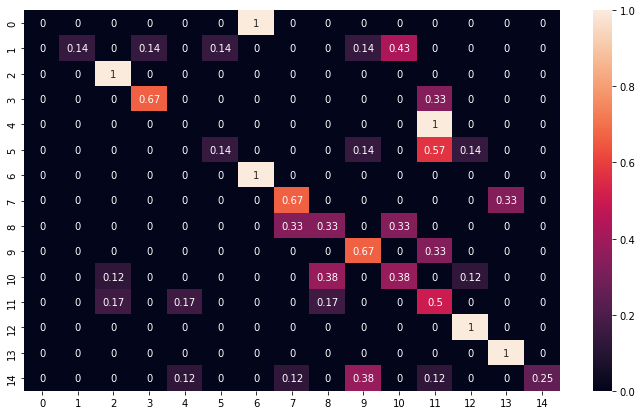

In [120]:
cm_kernel_df = pd.DataFrame(normalized_cm_kernel , index = [i for i in range(15)],
                     columns = [i for i in range(15)])
plt.figure(figsize = (12,7))
sn.heatmap(cm_kernel_df, annot=True)

In [82]:
#Error Correcting Output Code approach

In [83]:
print(model)

new_model(
  (pretrained): None
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
)


In [91]:
code_matrix = np.random.choice([0,1],size=(15,20))

In [92]:
def labels_for_functions(old_targets,code_matrix): 
    new_targets = [] 
    for i in range(code_matrix.shape[1]): 
        new_labels = np.zeros_like(old_targets)
        indices= np.argwhere((code_matrix.T)[i]==1)
        for i in range(len(new_labels)): 
            if (old_targets[i] in indices): 
                 new_labels[i] = 1
        new_targets.append(new_labels)
    
    return new_targets
                

In [94]:
new_train_targets = labels_for_functions(train_targets,code_matrix)

In [95]:
new_test_targets = labels_for_functions(test_targets,code_matrix)

In [96]:
len(new_targets)

20

In [97]:
def fit_multi_functions(prova_features,targets): 
    
    function_names = []
    for i in range(len(targets)):
        filename = "f"+str(i)+".joblib"
        #svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(train_features,train_targets)
        function_names.append(filename)
        classificator = svm.SVC(C=1).fit(prova_features,targets[i])
        joblib.dump(classificator,filename)
    
    return function_names 
        
        

In [99]:
classificator_names = fit_multi_functions(train_features,new_train_targets)

In [100]:
def predictor(features,classificator_names): 
    pred = [] 
    for name in classificator_names: 
        model = joblib.load(name)
        predictions = model.predict(features)
        pred.append(predictions)
    return np.array(pred)       

In [101]:
predictions = predictor(train_features,classificator_names)

In [105]:
def class_conversion(predictions,code_matrix):
    class_conv = [] 
    for i in range(len(predictions[0])): 
        classification = predictions[:,i]
        winn_class = code_matrix.shape[0]+1 
        minimum = code_matrix.shape[1]+2 
        for j in range(len(code_matrix)):
            d = (code_matrix[j,:]^predictions[:,i]).sum()
            if d<minimum: 
                minimum = d
                winning_class = j 
        class_conv.append(winning_class)
    return np.array(class_conv)

In [106]:
pred = class_conversion(predictions,code_matrix)

In [107]:
train_accuracy = (pred == train_targets).sum()/len(train_targets)

In [108]:
train_accuracy

0.546376329787234

In [109]:
test_predictions = predictor(test_features,classificator_names)

In [110]:
test_pred = class_conversion(test_predictions,code_matrix)
test_accuracy = (test_pred == test_targets).sum()/len(test_targets)

In [111]:
test_accuracy

0.421875

In [112]:
cm_svm_ecoc = confusion_matrix(test_targets, test_pred)

In [113]:
normalized_cm_ecoc = cm_svm_ecoc / cm_svm_ecoc.sum(axis=1)[:, np.newaxis]

<AxesSubplot:>

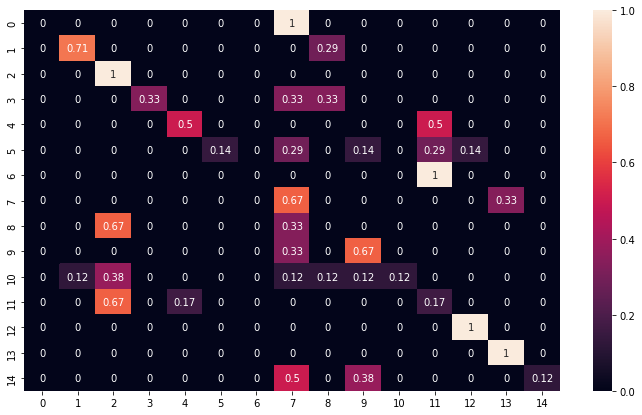

In [118]:
cm_ecoc_df = pd.DataFrame(normalized_cm_ecoc , index = [i for i in range(15)],
                     columns = [i for i in range(15)])
plt.figure(figsize = (12,7))
sn.heatmap(cm_ecoc_df, annot=True)